# This Notebook Explores Computer Vision Using MNIST Dataset.

In [2]:
# Required libraries are loaded. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

import cv2

In [3]:
# Files to be used.
path = "../../../Data/digit-recognizer/"
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


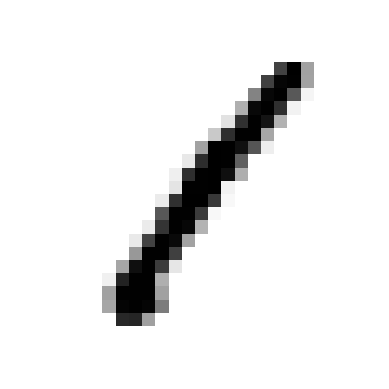

In [6]:
# Here we are visualizing a sample observation.
obs = train.iloc[0,][1:].to_numpy()
im = obs.reshape(28, 28)
plt.imshow(im, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
# Working with numpy is easier on sklearn.
X_train = train.loc[:,"pixel0":].to_numpy()
y_train = train.loc[:,"label"].to_numpy()
test = test.to_numpy()

### Grid Search KNeighbors for best parameter space.

In [9]:
# knn_clf = KNeighborsClassifier()

In [10]:
# Parameters to search for the best model.
# params = [{"n_neighbors": [2, 3, 4, 6], "weights": ["distance", "uniform"]}]

In [11]:
# grid_search = GridSearchCV(knn_clf, params, cv=5, scoring="accuracy", verbose=3)
# grid_search.fit(X_train, y_train)

In [12]:
# cvres = grid_search.cv_results_
 
# for mean_test_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(f"The mean_test_score is: {mean_test_score} and params: {params}")

### Grid Search SVM for best parameter space.

In [14]:
# {"kernel": ["poly"], "degree": [3, 4, 5], "C": [3, 4, 5], "coef0": [1, 2, 3]},
#params_svm = [{"dual": [False], "C": [1, 3, 4], "max_iter": [10000]}]

In [15]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [16]:
#grid_search_lin_svm = GridSearchCV(svm_clf, params_svm, scoring="accuracy", cv=3, verbose=True)
#grid_search_lin_svm.fit(X_train, y_train)

In [17]:
#cvres = grid_search_lin_svm.cv_results_

#for mean_test_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#    print(f"The mean_test_score is: {mean_test_score} and params: {params}")

### Error Analysis

In [19]:
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[4085,    0,    4,    2,    6,    7,   14,    1,   11,    2],
       [   0, 4634,   16,    7,    6,    1,    1,    7,    8,    4],
       [  13,    8, 4066,    9,   16,    2,    9,   28,   21,    5],
       [   4,    6,   38, 4183,    1,   49,    2,   14,   38,   16],
       [   5,    7,    8,    0, 3968,    1,   12,    8,    5,   58],
       [   8,    3,    5,   42,    8, 3689,   18,    1,   11,   10],
       [  20,    3,    4,    0,    7,   17, 4079,    0,    7,    0],
       [   5,   18,   28,    4,   19,    1,    0, 4278,    5,   43],
       [   8,   18,   13,   30,   17,   19,   13,    6, 3927,   12],
       [  14,    8,    4,   29,   54,   10,    0,   41,   19, 4009]],
      dtype=int64)

Let's visualize the above matrix

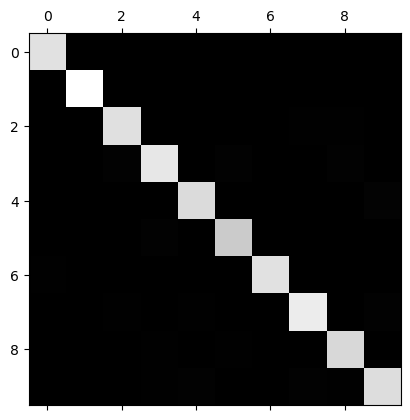

In [21]:
plt.matshow(conf_mx, cmap="gray")
plt.show()

The image shows that the classifier did a good job classifying the digits. However, let's focus on the errors.

In [23]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
norm_conf_mx

array([[9.88625363e-01, 0.00000000e+00, 9.68054211e-04, 4.84027106e-04,
        1.45208132e-03, 1.69409487e-03, 3.38818974e-03, 2.42013553e-04,
        2.66214908e-03, 4.84027106e-04],
       [0.00000000e+00, 9.89325363e-01, 3.41588386e-03, 1.49444919e-03,
        1.28095645e-03, 2.13492741e-04, 2.13492741e-04, 1.49444919e-03,
        1.70794193e-03, 8.53970965e-04],
       [3.11228154e-03, 1.91525018e-03, 9.73425904e-01, 2.15465645e-03,
        3.83050036e-03, 4.78812545e-04, 2.15465645e-03, 6.70337563e-03,
        5.02753172e-03, 1.19703136e-03],
       [9.19328890e-04, 1.37899333e-03, 8.73362445e-03, 9.61388187e-01,
        2.29832222e-04, 1.12617789e-02, 4.59664445e-04, 3.21765111e-03,
        8.73362445e-03, 3.67731556e-03],
       [1.22789784e-03, 1.71905697e-03, 1.96463654e-03, 0.00000000e+00,
        9.74459725e-01, 2.45579568e-04, 2.94695481e-03, 1.96463654e-03,
        1.22789784e-03, 1.42436149e-02],
       [2.10803689e-03, 7.90513834e-04, 1.31752306e-03, 1.10671937e-02,
   

In [24]:
np.fill_diagonal(norm_conf_mx, 0) # This elliminates correctly classified digits

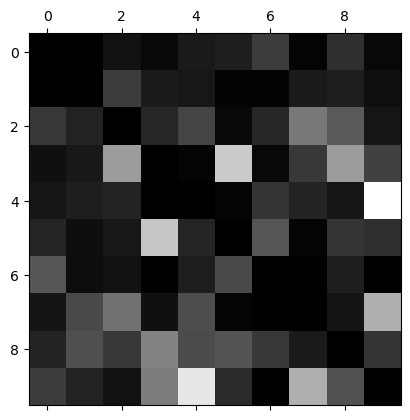

In [25]:
plt.matshow(norm_conf_mx, cmap="gray")
plt.show()

### Data Augmentation

In [27]:
from scipy.ndimage import shift

In [28]:
def shift_image(image, dx, dy):
    """
    This function is used to shift an image down, up, left and right.
    """
    
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dx, dy], cval=0)
    shifted_image = shifted_image.reshape([-1])
    return shifted_image

In [29]:
def augment_data(predictors, labels):
    """
    This function augments both the predictors and labels.
    """
    augmented_predictors = [image for image in predictors]
    augmented_labels = [label for label in labels]
    
    rotations = [(1,0),(-1,0),(0,-1),(0,1)]
    for dx, dy in rotations:
        for image, label in zip(predictors, labels):
            shifted_image = shift_image(image, dx, dy)
            augmented_predictors.append(shifted_image)
            augmented_labels.append(label)
    augmented_predictors = np.array(augmented_predictors)
    augmented_labels = np.array(augmented_labels)
    return augmented_predictors, augmented_labels
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

In [30]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

### Additional Preprocessing

Will pause on scaling the data as it seems to cause a decline in performance for knn.

In [33]:
# Standardize the training set.
# scaler = StandardScaler()
# X_train_augmented_scaled = scaler.fit_transform(X_train_augmented)
# test_scaled = scaler.fit_transform(test)

### Train KNeighbors on best parameters and augmented data.

In [35]:
#knn_clf = KNeighborsClassifier(**grid_search_lin_svm.best_params_)

In [36]:
#knn_clf.fit(X_tr  ain_augmented, y_train_augmented)
#predictions = knn_clf.predict(test)

In [37]:
#scores = cross_val_score(knn_clf, X_train_augmented_scaled, y_train_augmented, cv=5)
#print(np.mean(scores))

### Train SVM on best parameters and augmented data.

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train_augmented, y_train_augmented)
predictions = svm_clf.predict(test)

In [ ]:
scores = cross_val_score(svm_clf, X_train_augmented_scaled, y_train_augmented, cv=5)
print(np.mean(scores))

In [ ]:
df = pd.DataFrame()
df["ImageId"] = np.arange(1, 28001)
df["Label"] = predictions
df.to_csv("kneighbors_predictions.csv", index=False)